## Model: KNN Tree
Attribute Selection: None

In [86]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score, silhouette_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

def interpret_confusion_matrix(matrix, title, labels):
    encode, correct, errors, total = [],[],[],[]
    i=0
    for row in matrix:
        total.append(sum(row))
        correct.append(row[i])
        
        consider = row.tolist() 
        del consider[i] #remove correctly classified instances

        errors.append(sum(consider))
        i+=1

    fig = go.Figure(data=[go.Table(columnwidth=5, header=dict(values=["Class","Correctly Classified","Incorrectly Classified","Total"]),cells=dict(values=[labels, correct, errors, total]))])
    fig.update_layout(title= title,width=700,height=400)

    fig.show()

def determine_n_value(xtrain,ytrain,xtest,ytest):
    error =[]
    cv = []
    labels = []
    for k in range(1,25):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(xtrain,ytrain)
        ypred = clf.predict(xtest)
        cv_score=cross_val_score(clf,xtrain,ytrain, cv=10)
        error_rate = np.mean(ypred!=ytest)
        # stats.append([k,np.round(error_rate,4),np.array(cv_score).mean()])
        error.append(np.round(error_rate,4))
        cv.append(np.array(cv_score).mean())
        labels.append(k)

    #Plot results    
    data = [error, cv]
    titles = ['Error Rate vs. K Value (KNN)','Cross Validation Score vs. K Value (KNN)']
    colors = ["blue","r"]
    y_labels =['Error Rate','Cross Validation Score']
    fig,axis = plt.subplots(2,1)
  
    plt.figure(figsize=(20,6))
    for i in range(2):      
        axis[i].plot(range(1,25),data[i],color=colors[i], linestyle='dashed',marker='o',markerfacecolor=colors[i], markersize=5)
        axis[i].set_title(titles[i],loc='left', fontweight='bold',  style='italic',)
        axis[i].set_xlabel('K')
        axis[i].set_ylabel(y_labels[i])

    fig.tight_layout()
    plt.show()
    return [labels,error,cv]

labels = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

In [87]:
df = pd.read_csv("Data/DataEncoded.csv")

X=df.iloc[:,:-1]
y=df["NObeyesdad"]

#### Training, Testing

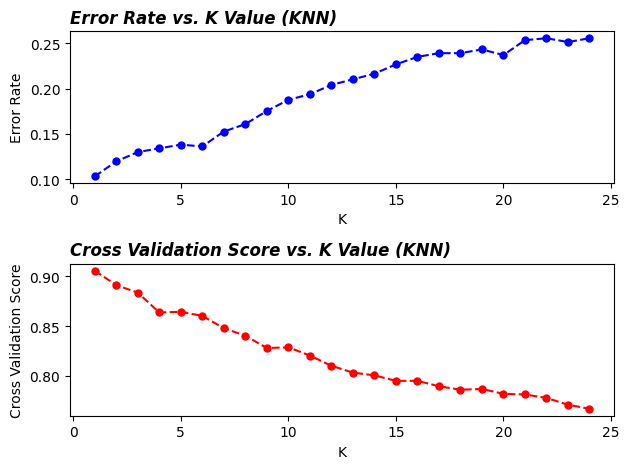

<Figure size 2000x600 with 0 Axes>

In [88]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y)

# determine n value
consider_n = determine_n_value(X_train,y_train,X_test,y_test)

fig = go.Figure(data=[go.Table(columnwidth=5, header=dict(values=["K Value","Error Rate","Cross Validation"]),
                cells=dict(values=consider_n))
                    ])
fig.update_layout(title="K Value vs Error Rate & Cross Validation Score",width=650,height=700)
fig.show()


You do not want a K value that is too small, this leads to overfitting. With that being said, we will use k = 4 since the cross validation score is high as well.

In [89]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
ypred = knn.predict(X_test)


#### Evaluation

Cross Validation Score: 0.8638072744449692
Precision Score: 0.8661913929811209
Recall Score: 0.865979381443299
F1 score: 0.8602198378587286
Accuracy: 0.865979381443299

Confusion Matrix 
----------------


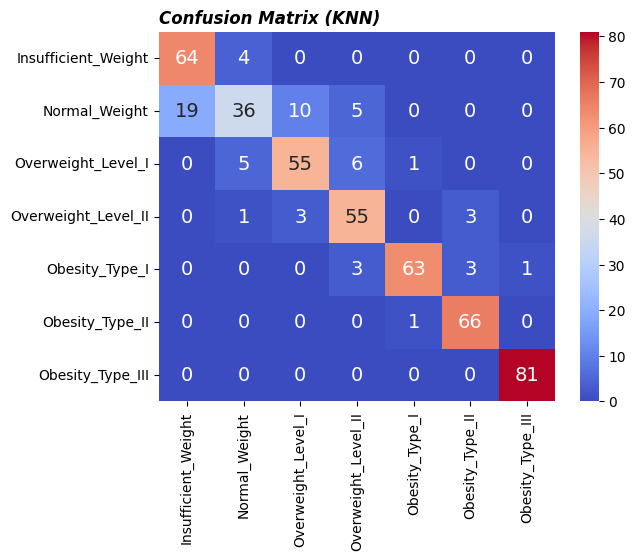

In [90]:
cv_score = np.array(cross_val_score(knn, X_train,y_train, cv=10)).mean()
cf_matrix = confusion_matrix(y_test,ypred)
metrics = precision_recall_fscore_support(y_test,ypred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]
accuracy= accuracy_score(y_test,ypred)

print("Cross Validation Score: {0}\nPrecision Score: {1}\nRecall Score: {2}\nF1 score: {3}\nAccuracy: {4}".format(cv_score,precision,recall,f1,accuracy))

print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, labels, labels), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix (KNN)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix,"Breakdown of Confusion Matrix (KNN)", labels)                   

#### Feature Elimination with Cross-Validation

Cross Validation Score: 0.8588130686517784
Precision Score: 0.8823628254040625
Recall Score: 0.8814432989690721
F1 score: 0.876441521278322
Accuracy: 0.8814432989690721

Confusion Matrix 
----------------


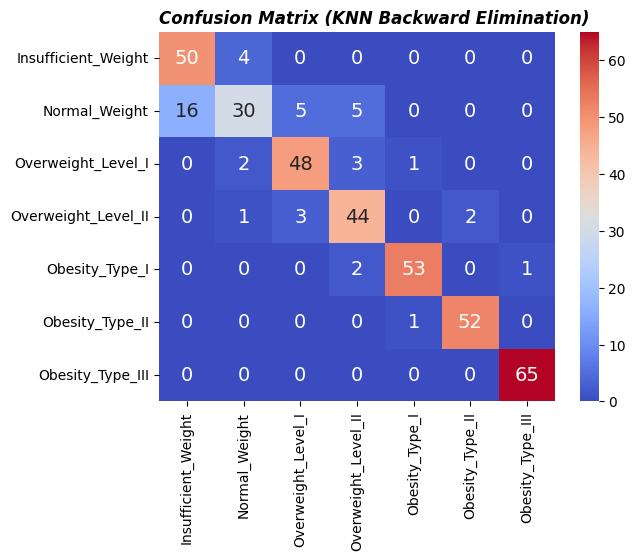

In [91]:

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

df = pd.read_csv("data/DataEncoded.csv")
X = df.drop(["NObeyesdad"], axis=1)
Y = df["NObeyesdad"]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=y)

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(xTrain, yTrain)
selector.support_

good_attributes = selector.get_feature_names_out(X.columns)

X = df[good_attributes]
Y = df["NObeyesdad"]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=y)


knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(xTrain,yTrain)
yPred = knn.predict(xTest)

cv_score = np.array(cross_val_score(knn, xTrain,yTrain, cv=10)).mean()
cf_matrix = confusion_matrix(yTest,yPred)
metrics = precision_recall_fscore_support(yTest,yPred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]
accuracy = accuracy_score(yTest,yPred)


print(f"Cross Validation Score: {cv_score}\nPrecision Score: {precision}\nRecall Score: {recall}\nF1 score: {f1}\nAccuracy: {accuracy}")

print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, labels, labels), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix (KNN Backward Elimination)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix,"Breakdown of Confusion Matrix (KNN Backward Elimination)", labels)              


#### Pearson Coefficent

Cross Validation Score: 0.8001695616211745
Precision Score: 0.8341324640410127
Recall Score: 0.8298969072164949
F1 score: 0.8263308259529405
Accuracy: 0.8298969072164949

Confusion Matrix 
----------------


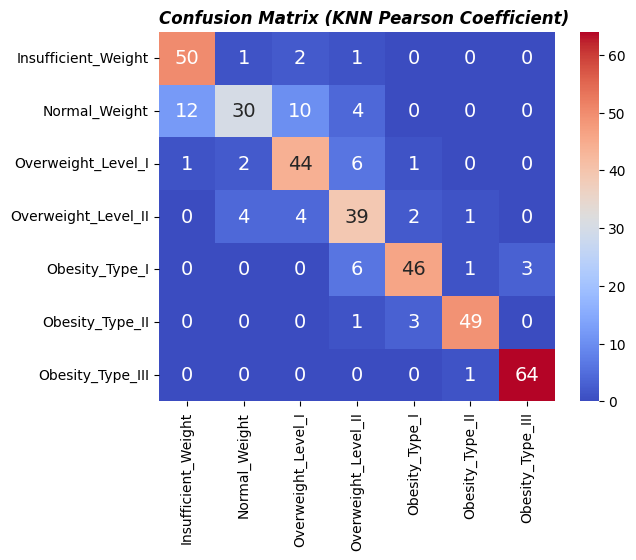

In [92]:
good_attributes = ["Age","Weight","CAEC"]

X = df[good_attributes]
Y = df["NObeyesdad"]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=y)


knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(xTrain,yTrain)
yPred = knn.predict(xTest)

cv_score = np.array(cross_val_score(knn, xTrain,yTrain, cv=10)).mean()
cf_matrix = confusion_matrix(yTest,yPred)
metrics = precision_recall_fscore_support(yTest,yPred,average="weighted")
precision,recall,f1=metrics[0],metrics[1],metrics[2]
accuracy = accuracy_score(yTest,yPred)


print(f"Cross Validation Score: {cv_score}\nPrecision Score: {precision}\nRecall Score: {recall}\nF1 score: {f1}\nAccuracy: {accuracy}")

print("\nConfusion Matrix \n----------------")
sns.heatmap(pd.DataFrame(cf_matrix, labels, labels), annot=True, annot_kws={"size": 14},cmap = 'coolwarm') # font size
plt.title("Confusion Matrix (KNN Pearson Coefficient)",loc='left', fontweight='bold',  style='italic')
plt.show()

interpret_confusion_matrix(cf_matrix,"Breakdown of Confusion Matrix (KNN Pearson Coefficient)", labels)              
